<a href="https://colab.research.google.com/github/farikazz/METOPEN/blob/main/EeksperimenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalasi dan Import Pustaka yang Dibutuhkan


In [ ]:
# Instalasi pustaka yang dibutuhkan
!pip install Sastrawi

# Pustaka untuk manipulasi data dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pemrosesan teks
import re
import string
import json
import requests
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_unduh
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Mengunduh dependensi NLTK
nltk_unduh('punkt')
nltk_unduh('punkt_tab')
nltk_unduh('stopwords')

# Pustaka untuk pembelajaran mesin
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

# Pustaka untuk pembelajaran mendalam
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GRU, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Menonaktifkan peringatan sistem
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Memuat Dataset Ulasan Aplikasi Gojek

In [ ]:
# Memuat dataset ulasan dari file CSV lokal
file_path = "Gojek.csv"
df = pd.read_csv(file_path)

# Menampilkan beberapa baris awal dari dataset
print("Data ulasan:")
df.head()

Data ulasan:


,userName,content,score,at,appVersion
0,Yuga Edit,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3
1,ff burik,Lambat sekali sekarang ini bosssku apk gojek g...,3,2021-11-30 15:40:38,4.9.3
2,Anisa Suci Rahmayuliani,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3
3,naoki yakuza,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3
4,Trio Sugianto,Mantap,5,2022-01-15 10:05:27,4.9.3


pelabelan data

In [ ]:
df = df[['content', 'score']].dropna()
df.head()

,content,score
0,akun gopay saya di blok,1
1,Lambat sekali sekarang ini bosssku apk gojek g...,3
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4
3,Baru download gojek dan hape baru trus ditop u...,1
4,Mantap,5


In [ ]:
def label_sentiment(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:
        return 'positif'

df['label'] = df['score'].apply(label_sentiment)
df['label'].value_counts()

,count
label,
positif,161369
negatif,54171
netral,9460


Exploratory Data Analysis (EDA) Menampilkan Informasi Umum dan Pengecekan Data Kosong

In [ ]:
# Menampilkan informasi dasar dari dataset awal (df)
df.info()

# Mengecek apakah ada nilai kosong di setiap kolom
print("Nilai yang hilang:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 225000 entries, 0 to 225001
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  225000 non-null  object
 1   score    225000 non-null  int64 
 2   label    225000 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.9+ MB
Nilai yang hilang:
content    0
score      0
label      0
dtype: int64


Under-Sampling Data

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Menentukan fitur dan label awal
X = df[['content', 'score']]
y = df['label']

# Target jumlah berdasarkan kelas 'negatif'
target_count = y.value_counts()['negatif']

# Step 1: Undersample 'positif' ke target_count
undersampler = RandomUnderSampler(sampling_strategy={'positif': target_count}, random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# Step 2: Oversample 'netral' ke target_count
oversampler = RandomOverSampler(sampling_strategy={'netral': target_count}, random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X_under, y_under)

# Buat DataFrame hasil kombinasi
df_balanced = pd.DataFrame(X_balanced, columns=['content', 'score'])
df_balanced['label'] = y_balanced

# Cek hasil akhir
print("Distribusi label setelah kombinasi undersampling dan oversampling:")
print(Counter(y_balanced))


Distribusi label setelah kombinasi undersampling dan oversampling:
Counter({'negatif': 54171, 'netral': 54171, 'positif': 54171})


Distribusi Sentimem Setelah Under-Sampling

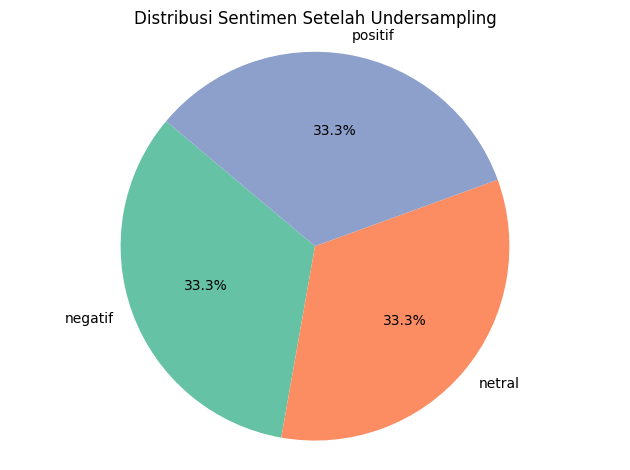


Distribusi label setelah undersampling:
label
negatif    54171
netral     54171
positif    54171
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
jumlah_sentimen_setelah = df_balanced['label'].value_counts()

# Pie chart distribusi sentimen setelah undersampling
plt.pie(jumlah_sentimen_setelah,
        labels=jumlah_sentimen_setelah.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("Set2"))
plt.title('Distribusi Sentimen Setelah Undersampling')
plt.axis('equal')

# Tampilkan kedua pie chart secara rapi
plt.tight_layout()
plt.show()

print("\nDistribusi label setelah undersampling:")
print(jumlah_sentimen_setelah)


Visualisasi Distribusi Rating Ulasan

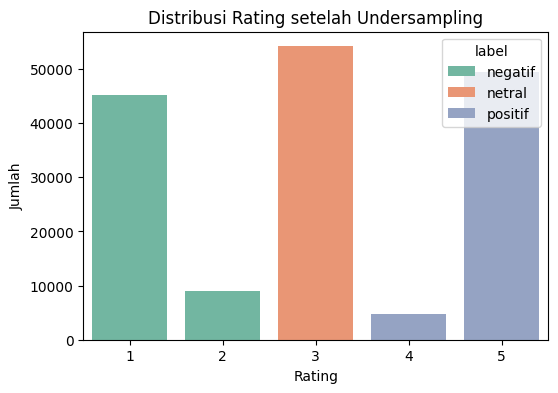

Jumlah ulasan per rating setelah undersampling:
score
3    54171
5    49450
1    45229
2     8942
4     4721
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_balanced['score'], hue=df_balanced['label'], palette='Set2')
plt.title("Distribusi Rating setelah Undersampling")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

print("Jumlah ulasan per rating setelah undersampling:")
print(df_balanced['score'].value_counts())



Text Preprocessing

In [ ]:
import re

def proses_teks(teks):
    if isinstance(teks, str) or pd.isna(teks):
        if pd.isna(teks):
            teks = ''
        else:
            teks = re.sub(r'@[A-Za-z0-9_]+', '', teks)
            teks = re.sub(r'#[A-Za-z0-9_]+', '', teks)
            teks = re.sub(r'[²]', ' ', teks)
            teks = re.sub(r'\d+', ' ', teks)
            teks = re.sub(r'[^\w\s]', ' ', teks)
            teks = teks.strip()
            teks = teks.lower()
    else:
        print(f"Tipe data tidak valid: {type(teks)}")
        teks = str(teks)
    return teks

# Terapkan ke kolom content
df['clean_review'] = df['content'].apply(proses_teks)

# Tampilkan contoh hasil
print(df[['clean_review', 'score', 'label']].head(10))


                                        clean_review  score    label
0                            akun gopay saya di blok      1  negatif
1  lambat sekali sekarang ini bosssku apk gojek g...      3   netral
2  kenapa sih dari kemarin sy buka aplikasi gojek...      4  positif
3  baru download gojek dan hape baru trus ditop u...      1  negatif
4                                             mantap      5  positif
5                                              bagus      4  positif
6                                          coba dulu      2  negatif
7                                                 ok      5  positif
8  gimana ini kak pin saya salah terus padahal ud...      1  negatif
9  biar aman kamu tidak bisa pakai gojek jadi say...      1  negatif


Tokenisasi Teks


In [ ]:
from nltk.tokenize import word_tokenize

# Fungsi tokenisasi
def tokenisasi_teks(teks):
    return word_tokenize(teks)

# Terapkan ke kolom clean_review
df['token_review'] = df['clean_review'].apply(tokenisasi_teks)

# Tampilkan hasil
print(df[['token_review']].head(10))


                                        token_review
0                      [akun, gopay, saya, di, blok]
1  [lambat, sekali, sekarang, ini, bosssku, apk, ...
2  [kenapa, sih, dari, kemarin, sy, buka, aplikas...
3  [baru, download, gojek, dan, hape, baru, trus,...
4                                           [mantap]
5                                            [bagus]
6                                       [coba, dulu]
7                                               [ok]
8  [gimana, ini, kak, pin, saya, salah, terus, pa...
9  [biar, aman, kamu, tidak, bisa, pakai, gojek, ...


Penghapusan Stopwords

In [ ]:
from nltk.corpus import stopwords

def filter_stopwords(teks):
    daftar_stopwords = set(stopwords.words('indonesian'))
    daftar_stopwords_english = set(stopwords.words('english'))

    daftar_stopwords.update(daftar_stopwords_english)
    daftar_stopwords.update([
        'dong', 'nih', 'aja', 'kok', 'deh', 'kan', 'si', 'cuma', 'doang',
        'makasih', 'makasi', 'makasii', 'terima', 'kasih', 'bgt', 'banget',
        'ajaib', 'tolong', 'dah', 'udah', 'udahh', 'enggak', 'nggak',
        'cuy', 'bro', 'sis', 'mau', 'minta', 'aplikasi', 'gojek',
        'driver', 'ojol', 'gofood', 'gomart', 'gocar', 'gobiz',
        'gopay', 'gopoints', 'go', 'nya', 'nyaa', 'gaes', 'temen', 'teman',
        'dikit', 'lumayan', 'oke', 'ok', 'yah', 'hmm', 'wkwk', 'wkwkwk',    'mau', 'minta', 'pengen', 'lagi', 'dong', 'jadi', 'biar', 'lah', 'mah', 'loh', 'cie',
        'bang', 'mbak', 'mas', 'pak', 'bu', 'om', 'tante', 'kak', 'dek', 'sobat', 'aplikasi', 'gojek', 'driver', 'ojol', 'gofood', 'gomart', 'gocar', 'gobiz',
        'gopay', 'gopoints', 'go', 'grab', 'tokped', 'shopee', 'aja', 'banget', 'gitu', 'kayak', 'kayaknya', 'biasanya', 'sering', 'jarang', 'serasa',
        'emang', 'sih', 'dong', 'deh', 'kan', 'nih', 'loh', 'lagi', 'udah', 'sama', 'tanpa', 'dengan', 'dalam', 'luar', 'itu', 'ini', 'ada', 'adalah', 'buat',
        'lebih', 'kurang', 'seperti', 'biasa', 'setiap', 'semua', 'beberapa'
    ])

    hasil_filter = [kata for kata in teks if kata not in daftar_stopwords]
    return hasil_filter

# Terapkan
df['stopword_removed'] = df['token_review'].apply(filter_stopwords)

# Lihat hasilnya
print(df[['stopword_removed']].head(10))


                                    stopword_removed
0                                       [akun, blok]
1                   [lambat, bosssku, apk, gk, kaya]
2  [kemarin, sy, buka, bintang, kalo, normal, sy,...
3  [download, hape, trus, ditop, u, transaksi, di...
4                                           [mantap]
5                                            [bagus]
6                                             [coba]
7                                                 []
8                  [gimana, pin, salah, ubah, salah]
9                      [aman, pakai, uninstal, aman]


Pemrosesan Kata Slang (Bahasa Gaul)

In [ ]:
# 1. Kamus slang yang dijabarkan dan diperluas
kata_slang = {
    "gk": "nggak",
    "ga": "nggak",
    "tdk": "tidak",
    "nggk": "nggak",
    "bgt": "banget",
    "bngt": "banget",
    "dgn": "dengan",
    "udh": "sudah",
    "aja": "saja",
    "tp": "tapi",
    "krn": "karena",
    "bgtu": "begitu",
    "bgitu": "begitu",
    "sm": "sama",
    "sy": "saya",
    "gw": "saya",
    "gue": "saya",
    "lu": "kamu",
    "loe": "kamu",
    "lg": "lagi",
    "jg": "juga",
    "dr": "dari",
    "dri": "dari",
    "trs": "terus",
    "trus": "terus",
    "bbrp": "beberapa",
    "pake": "menggunakan",
    "pkai": "menggunakan",
    "dpt": "dapat",
    "ajaib": "aneh",
    "td": "tadi",
    "tdi": "tadi",
    "skrg": "sekarang",
    "bsk": "besok",
    "knp": "kenapa",
    "gmn": "bagaimana",
    "nnti": "nanti",
    "ntar": "nanti",
    "smg": "semoga",
    "tq": "terima kasih",
    "makasih": "terima kasih",
    "makasi": "terima kasih",
    "thx": "terima kasih",
    "thanks": "terima kasih",
    "plis": "tolong",
    "pls": "tolong",
    "banget": "sangat",
    "yaudah": "baiklah",
    "yah": "ya",
    "sip": "baik",
    "mantul": "mantap betul",
    "mantap": "hebat",
    "kzl": "kesal",
    "kesel": "kesal",
    "cape": "lelah",
    "capek": "lelah",
    "btw": "ngomong-ngomong",
    "wkwk": "",
    "wkwkwk": "",
    "lol": "",
    "haha": "",
    "hehe": ""
}

# 2. Fungsi normalisasi slang
def normalisasi_slang(teks, kamus_slang):
    return [kamus_slang.get(kata, kata) for kata in teks]

# 3. Terapkan ke DataFrame
df['normalized'] = df['stopword_removed'].apply(lambda tokens: normalisasi_slang(tokens, kata_slang))

# 4. Tampilkan hasil
print(df[['stopword_removed', 'normalized']].head(10))


                                    stopword_removed  \
0                                       [akun, blok]   
1                   [lambat, bosssku, apk, gk, kaya]   
2  [kemarin, sy, buka, bintang, kalo, normal, sy,...   
3  [download, hape, trus, ditop, u, transaksi, di...   
4                                           [mantap]   
5                                            [bagus]   
6                                             [coba]   
7                                                 []   
8                  [gimana, pin, salah, ubah, salah]   
9                      [aman, pakai, uninstal, aman]   

                                          normalized  
0                                       [akun, blok]  
1                [lambat, bosssku, apk, nggak, kaya]  
2  [kemarin, saya, buka, bintang, kalo, normal, s...  
3  [download, hape, terus, ditop, u, transaksi, d...  
4                                            [hebat]  
5                                            [bagus] 

Pipeline Pembersihan dan Normalisasi Teks
Memuat Leksikon Sentimen (Positive & Negative Word Lists)

In [ ]:
import re
import pandas as pd

def proses_teks(teks):
    if pd.isna(teks):
        teks = ''
    elif not isinstance(teks, str):
        teks = str(teks)
    teks = teks.lower()
    teks = re.sub(r'@[A-Za-z0-9_]+', '', teks)
    teks = re.sub(r'#[A-Za-z0-9_]+', '', teks)
    teks = re.sub(r'[²]', ' ', teks)
    teks = re.sub(r'\d+', ' ', teks)
    teks = re.sub(r'[^\w\s]', ' ', teks)
    teks = re.sub(r'\s+', ' ', teks)
    teks = teks.strip()
    return teks


Data Preparation

In [ ]:
# Gunakan df_balanced
df_balanced['clean_content'] = df_balanced['content'].apply(proses_teks)

# Fitur teks dan label numerik
fitur = df_balanced['clean_content']
label = df_balanced['label'].map({'negatif': 0, 'netral': 1, 'positif': 2})
label = label.fillna(1)


Feature Engineering
Vektorisasi Teks Menggunakan TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000)
fitur_tfidf = tfidf.fit_transform(fitur)

print("Ringkasan Fitur dan Data:")
print(f"Dimensi fitur TF-IDF: {fitur_tfidf.shape}")


Ringkasan Fitur dan Data:
Dimensi fitur TF-IDF: (162513, 10000)



Praprocessing Teks untuk Model LSTM

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(fitur)

fitur_sekuensial = tokenizer.texts_to_sequences(fitur)
fitur_padat = pad_sequences(fitur_sekuensial, maxlen=100)

print(f"Jumlah kelas: {len(np.unique(label))}")
print(f"Dimensi urutan fitur: {fitur_padat.shape}")
print(f"Ukuran kosa kata: {len(tokenizer.word_index)} kata")

# Split untuk LSTM
fitur_latih_lstm, fitur_uji_lstm, label_latih_lstm, label_uji_lstm = train_test_split(
    fitur_padat, label, test_size=0.2, random_state=42
)
fitur_latih_lstm, fitur_validasi_lstm, label_latih_lstm, label_validasi_lstm = train_test_split(
    fitur_latih_lstm, label_latih_lstm, test_size=0.125, random_state=42
)

print("Total Sampel:")
print(f"Set pelatihan: {fitur_latih_lstm.shape[0]} sampel")
print(f"Set validasi : {fitur_validasi_lstm.shape[0]} sampel")
print(f"Set pengujian: {fitur_uji_lstm.shape[0]} sampel")


Jumlah kelas: 3
Dimensi urutan fitur: (162513, 100)
Ukuran kosa kata: 56870 kata
Total Sampel:
Set pelatihan: 113758 sampel
Set validasi : 16252 sampel
Set pengujian: 32503 sampel



Membangun dan Melatih Model LSTM untuk Klasifikasi Sentimen

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Buat model LSTM
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),  # Sesuai tokenizer & pad_sequences
    SpatialDropout1D(0.4),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')  # 3 kelas: negatif, netral, positif
])

# Kompilasi model
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Callbacks
callback_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
callback_lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2
)

callbacks = [callback_early_stopping, callback_lr_reduction]

# Latih model (gunakan data hasil padding & label numerik)
riwayat_latihan = model_lstm.fit(
    fitur_latih_lstm, label_latih_lstm,
    validation_data=(fitur_validasi_lstm, label_validasi_lstm),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/5
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 641s 357ms/step - accuracy: 0.6453 - loss: 0.7660 - val_accuracy: 0.7477 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 2/5
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 677s 355ms/step - accuracy: 0.7594 - loss: 0.5989 - val_accuracy: 0.7656 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 3/5
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 640s 360ms/step - accuracy: 0.7900 - loss: 0.5303 - val_accuracy: 0.7889 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 4/5
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 639s 359ms/step - accuracy: 0.8149 - loss: 0.4793 - val_accuracy: 0.8037 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 5/5
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 681s 359ms/step - accuracy: 0.8285 - loss: 0.4455 - val_accuracy: 0.8086 - val_loss: 0.5066 - learning_rate: 0.0010


Evaluasi dan Visualisasi Performa Model LSTM

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - accuracy: 0.8150 - loss: 0.4995

Evaluasi Model LSTM
Akurasi pelatihan per epoch terakhir: 0.8265
Akurasi pengujian akhir: 0.8135
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step

Kelas unik dalam label_uji_lstm:
[0 1 2]

Kelas unik dalam prediksi:
[0 1 2]

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.84      0.76      0.79     10651
      netral       0.75      0.80      0.77     10876
     positif       0.86      0.89      0.87     10976

    accuracy                           0.81     32503
   macro avg       0.81      0.81      0.81     32503
weighted avg       0.81      0.81      0.81     32503

label
2    10976
1    10876
0    10651
Name: count, dtype: int64


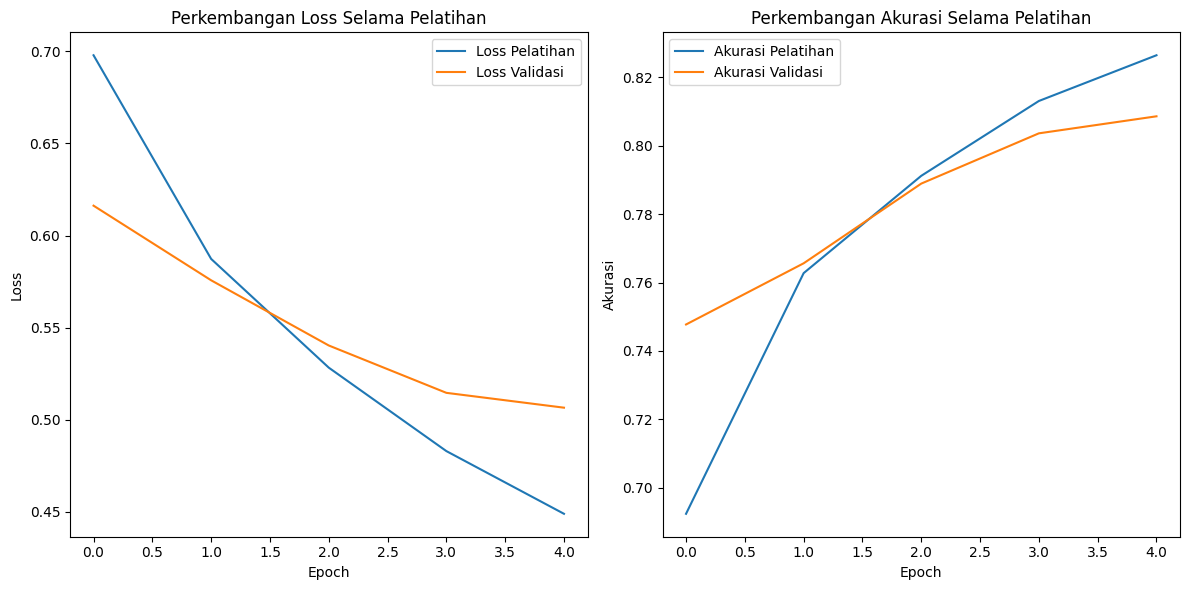

In [ ]:
# Mengambil nilai akurasi pelatihan terakhir
akurasi_latih = riwayat_latihan.history['accuracy']

# Evaluasi terhadap data pengujian
kerugian_uji, akurasi_lstm = model_lstm.evaluate(fitur_uji_lstm, label_uji_lstm)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model LSTM")
print(f"Akurasi pelatihan per epoch terakhir: {akurasi_latih[-1]:.4f}")
print(f"Akurasi pengujian akhir: {akurasi_lstm:.4f}")

# Prediksi terhadap data uji
y_prediksi = np.argmax(model_lstm.predict(fitur_uji_lstm), axis=1)

# Check the unique values in labels
print("\nKelas unik dalam label_uji_lstm:")
unique_labels = np.unique(label_uji_lstm)
print(unique_labels)

print("\nKelas unik dalam prediksi:")
unique_preds = np.unique(y_prediksi)
print(unique_preds)

# Menampilkan laporan klasifikasi dengan label yang ada
print("\nLaporan Klasifikasi:")
# Get the actual classes present in both true and predicted labels
all_classes = sorted(list(set(np.concatenate([unique_labels, unique_preds]))))
all_classes = [int(x) for x in all_classes]
# Create target names based on actual classes
target_names = [['negatif', 'netral', 'positif'][i] for i in all_classes] if len(all_classes) <= 3 else [f'class_{i}' for i in all_classes]

# Generate classification report with only the classes that are present
print(classification_report(label_uji_lstm, y_prediksi, labels=all_classes, target_names=target_names))

# Show the value counts
if hasattr(label_uji_lstm, 'value_counts'):
    print(label_uji_lstm.value_counts())
else:
    print("Distribusi label pengujian:")
    unique, counts = np.unique(label_uji_lstm, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"Kelas {u}: {c} sampel")

# Visualisasi loss dan akurasi selama pelatihan
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(riwayat_latihan.history['loss'], label='Loss Pelatihan')
plt.plot(riwayat_latihan.history['val_loss'], label='Loss Validasi')
plt.title('Perkembangan Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(riwayat_latihan.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(riwayat_latihan.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Perkembangan Akurasi Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fungsi untuk prediksi sentimen satu kalimat dari user
def uji_input_sentimen():
    # Input dari user
    teks_input = input("Masukkan kalimat yang ingin diuji: ")

    # Praproses teks
    teks_bersih = proses_teks(teks_input)

    # Tokenisasi dan padding
    sekuens_teks = tokenizer.texts_to_sequences([teks_bersih])
    sekuens_pad = pad_sequences(sekuens_teks, maxlen=100)  # Sesuai input_length LSTM

    # Prediksi menggunakan model
    prediksi = model_lstm.predict(sekuens_pad, verbose=0)
    label_index = np.argmax(prediksi)
    label = ['negatif', 'netral', 'positif'][label_index]
    skor = float(prediksi[0][label_index])
    distribusi = prediksi[0]

    # Tampilkan hasil
    print("\n=== Hasil Analisis Sentimen ===")
    print(f"Teks Asli: {teks_input}")
    print(f"Sentimen: {label}")
    print(f"Skor Probabilitas: {skor:.4f}")
    print(f"Distribusi (negatif, netral, positif): {distribusi}")

# Panggil fungsi ini untuk melakukan pengujian
uji_input_sentimen()


Masukkan kalimat yang ingin diuji: aplikasi bagus

=== Hasil Analisis Sentimen ===
Teks Asli: aplikasi bagus
Sentimen: positif
Skor Probabilitas: 0.8234
Distribusi (negatif, netral, positif): [0.05526476 0.12131177 0.8234235 ]


Visualisasi Confusion Matrix Model LSTM

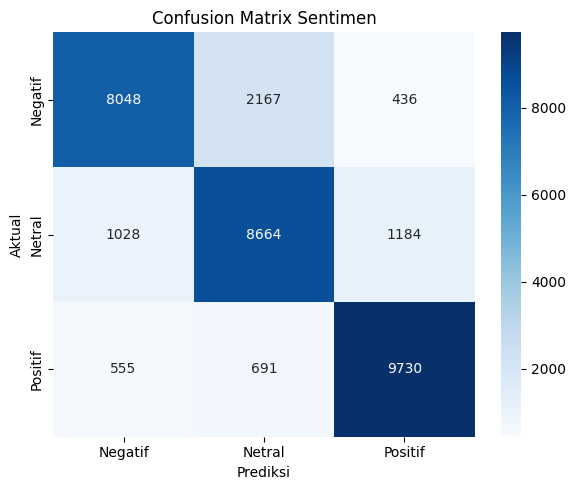

In [ ]:
# Membuat confusion matrix
matriks_konfusi = confusion_matrix(label_uji_lstm, y_prediksi)

# Menentukan label kelas
label_kategori = ['Negatif', 'Netral', 'Positif']

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(matriks_konfusi, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_kategori, yticklabels=label_kategori)
plt.title('Confusion Matrix Sentimen')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()

Menghitung Akurasi, Precision, Recall, dan F1-score dari Confusion Matrix

In [ ]:
# Ambil nilai dari confusion matrix
TN, FP, FN, TP = None, None, None, None  # placeholder untuk binary, kita hitung secara multi-kelas

# Mengambil nilai matrix
cm = confusion_matrix(label_uji_lstm, y_prediksi)
print("Confusion Matrix:")
print(cm)

# Hitung metrik per kelas
for i, kelas in enumerate(['Negatif', 'Netral', 'Positif']):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f"\nKelas: {kelas}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

# Hitung akurasi keseluruhan
akurasi_total = np.trace(cm) / np.sum(cm)
print(f"\nAkurasi Keseluruhan: {akurasi_total:.4f}")


Confusion Matrix:
[[8048 2167  436]
 [1028 8664 1184]
 [ 555  691 9730]]

Kelas: Negatif
  Precision: 0.8356
  Recall:    0.7556
  F1-score:  0.7936

Kelas: Netral
  Precision: 0.7520
  Recall:    0.7966
  F1-score:  0.7736

Kelas: Positif
  Precision: 0.8573
  Recall:    0.8865
  F1-score:  0.8716

Akurasi Keseluruhan: 0.8135


Traditional Machine Learning Models
SVM + TF-IDF (80/20)
Membagi Data Pelatihan dan Pengujian

In [ ]:
# Membagi Data menjadi Set Pelatihan dan Pengujian
from sklearn.model_selection import train_test_split # Import train_test_split

X_latih_svm, X_uji_svm, y_latih_svm, y_uji_svm = train_test_split(fitur_tfidf, label, test_size=0.2, random_state=42)

print("Total Sampel:")
print(f"Set pelatihan: {X_latih_svm.shape[0]} sampel")
print(f"Set pengujian: {X_uji_svm.shape[0]} sampel")

Total Sampel:
Set pelatihan: 130010 sampel
Set pengujian: 32503 sampel


Pelatihan dan Prediksi Model SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. Standarisasi data with with_mean=False for sparse matrix
scaler = StandardScaler(with_mean=False) #  This line is changed
X_latih_svm_scaled = scaler.fit_transform(X_latih_svm)
X_uji_svm_scaled = scaler.transform(X_uji_svm)

# 2. Inisialisasi LinearSVC dan kalibrasi untuk output probabilitas
base_svm = LinearSVC(max_iter=10000)  # Naikkan max_iter agar pasti konvergen
model_svm = CalibratedClassifierCV(base_svm, cv=3)  # Mengkalibrasi output probabilitas

# 3. Latih model
print("Melatih model, mohon tunggu...")
model_svm.fit(X_latih_svm_scaled, y_latih_svm)

# 4. Prediksi
y_pred_svm = model_svm.predict(X_uji_svm_scaled)

# 5. Evaluasi
print("Akurasi:", accuracy_score(y_uji_svm, y_pred_svm))
print("\nLaporan Klasifikasi:\n", classification_report(y_uji_svm, y_pred_svm))

# 6. (Opsional) Probabilitas prediksi
y_prob_svm = model_svm.predict_proba(X_uji_svm_scaled)

Melatih model, mohon tunggu...
Akurasi: 0.7732516998430914

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     10651
           1       0.74      0.70      0.72     10876
           2       0.82      0.88      0.85     10976

    accuracy                           0.77     32503
   macro avg       0.77      0.77      0.77     32503
weighted avg       0.77      0.77      0.77     32503



Evaluasi Model SVM Berbasis TF-IDF


Evaluasi Model SVM + TF-IDF

Akurasi Latih: 0.3322
Akurasi Uji: 0.7733

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.76      0.74      0.75     10651
      netral       0.74      0.70      0.72     10876
     positif       0.82      0.88      0.85     10976

    accuracy                           0.77     32503
   macro avg       0.77      0.77      0.77     32503
weighted avg       0.77      0.77      0.77     32503



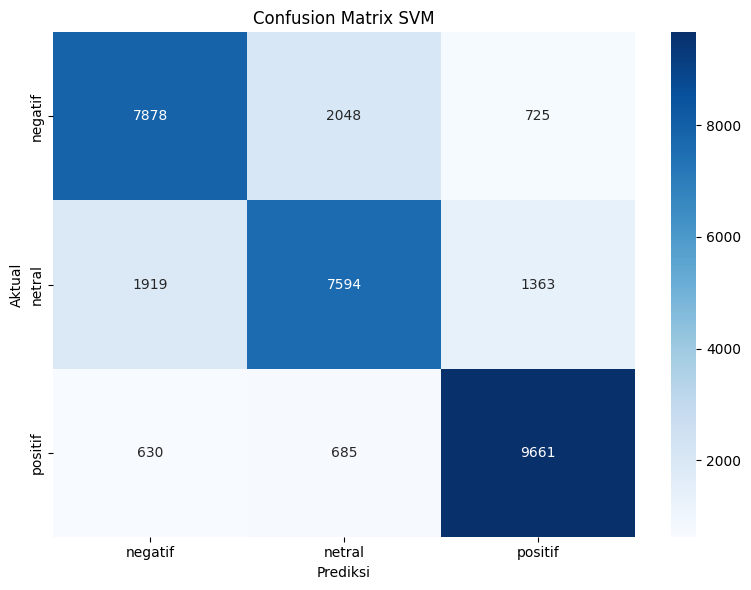

In [ ]:
# Evaluasi Model
akurasi_latih_svm = accuracy_score(y_latih_svm, model_svm.predict(X_latih_svm))
akurasi_svm = accuracy_score(y_uji_svm, y_pred_svm)

print("\nEvaluasi Model SVM + TF-IDF")
print(f'\nAkurasi Latih: {akurasi_latih_svm:.4f}')
print(f'Akurasi Uji: {akurasi_svm:.4f}')

print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_svm, y_pred_svm, target_names=['negatif', 'netral', 'positif']))

# Plot Matriks Kebingungannya
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_uji_svm, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()


In [ ]:
# Fungsi pengujian satu kalimat menggunakan model SVM
def uji_input_svm():
    # Input dari user
    teks_input = input("Masukkan kalimat untuk diuji dengan SVM: ")

    # Praproses teks
    teks_bersih = proses_teks(teks_input)

    # Transformasi dengan TF-IDF (menggunakan tfidf yang sudah fit sebelumnya)
    tfidf_input = tfidf.transform([teks_bersih])

    # Prediksi menggunakan model SVM
    prediksi = model_svm.predict(tfidf_input)[0]

    # Konversi label angka ke nama
    label_nama = {0: 'negatif', 1: 'netral', 2: 'positif'}.get(prediksi, "tidak diketahui")

    # Tampilkan hasil
    print("\n=== Hasil Analisis Sentimen (SVM) ===")
    print(f"Teks: {teks_input}")
    print(f"Prediksi Sentimen: {label_nama} (Label: {prediksi})")

# Contoh pemanggilan fungsi
uji_input_svm()


Masukkan kalimat untuk diuji dengan SVM: aplikasi jelek

=== Hasil Analisis Sentimen (SVM) ===
Teks: aplikasi jelek
Prediksi Sentimen: positif (Label: 2)



Random Forest + TF-IDF (70/30)
Membagi Data Pelatihan dan Pengujian

In [ ]:
# Bagi Data menjadi Set Latih dan Set Uji (70% Latih, 30% Uji)
X_latih_rf, X_uji_rf, y_latih_rf, y_uji_rf = train_test_split(fitur_tfidf, label, test_size=0.3, random_state=42)

print("Jumlah Sampel: ")
print(f"Set Latih: {X_latih_rf.shape[0]} sampel")
print(f"Set Uji: {X_uji_rf.shape[0]} sampel")

Jumlah Sampel: 
Set Latih: 113759 sampel
Set Uji: 48754 sampel


Inisialisasi dan Pelatihan Model Random Forest untuk Klasifikasi Sentimen

In [ ]:
# Inisialisasi Model Random Forest dengan Penyesuaian Hyperparameter
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Latih Model
rf_model.fit(X_latih_rf, y_latih_rf)

# Lakukan Prediksi
y_pred_rf = rf_model.predict(X_uji_rf)

Evaluasi Model Random Forest dengan Representasi TF-IDF


Evaluasi Model Random Forest dengan TF-IDF
Akurasi Latih: 0.8905
Akurasi Uji: 0.8515

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.82      0.90      0.86     16119
      netral       0.91      0.79      0.85     16317
     positif       0.84      0.86      0.85     16318

    accuracy                           0.85     48754
   macro avg       0.86      0.85      0.85     48754
weighted avg       0.86      0.85      0.85     48754



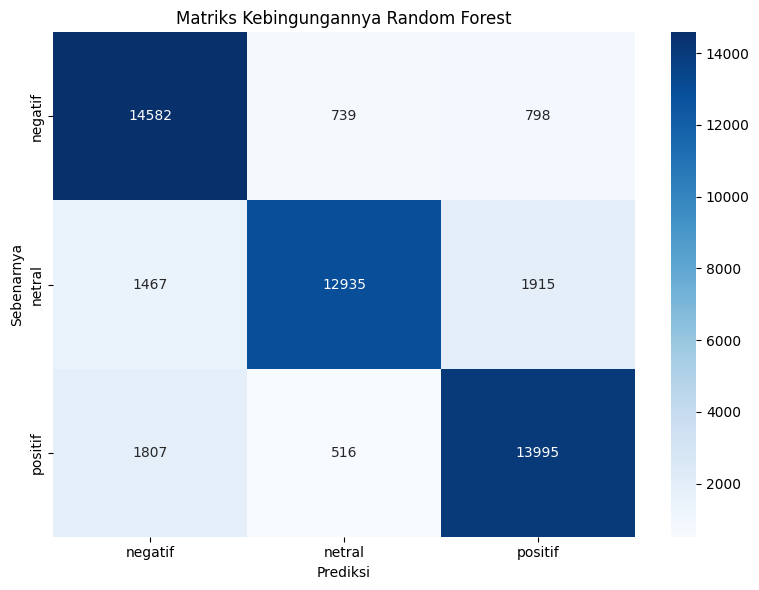

In [ ]:
# Evaluasi Model
akurat_latih = accuracy_score(y_latih_rf, rf_model.predict(X_latih_rf))
akurat_uji_rf = accuracy_score(y_uji_rf, y_pred_rf)

print("\nEvaluasi Model Random Forest dengan TF-IDF")
print(f"Akurasi Latih: {akurat_latih:.4f}")
print(f"Akurasi Uji: {akurat_uji_rf:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_rf, y_pred_rf, target_names=['negatif', 'netral', 'positif']))

# Plot Matriks Kebingungannya
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_uji_rf, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Matriks Kebingungannya Random Forest')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.tight_layout()
plt.show()


In [ ]:
# Fungsi pengujian satu kalimat menggunakan model Random Forest
def uji_input_rf():
    # Ambil input teks dari pengguna
    teks_input = input("Masukkan kalimat untuk diuji dengan Random Forest: ")

    # Proses teks: bersihkan seperti data latih
    teks_bersih = proses_teks(teks_input)

    # Transformasi TF-IDF (pastikan tfidf sudah fit)
    tfidf_input = tfidf.transform([teks_bersih])

    # Prediksi dengan model Random Forest
    prediksi = rf_model.predict(tfidf_input)[0]

    # Konversi label ke nama
    label_nama = {0: 'negatif', 1: 'netral', 2: 'positif'}.get(prediksi, "tidak diketahui")

    # Tampilkan hasil
    print("\n=== Hasil Analisis Sentimen (Random Forest) ===")
    print(f"Teks: {teks_input}")
    print(f"Prediksi Sentimen: {label_nama} (Label: {prediksi})")

# Contoh pemanggilan fungsi
uji_input_rf()


Masukkan kalimat untuk diuji dengan Random Forest: aplikasi jelek

=== Hasil Analisis Sentimen (Random Forest) ===
Teks: aplikasi jelek
Prediksi Sentimen: negatif (Label: 0)


Perbandingan Performa Model

In [ ]:
# Membuat tabel ringkasan performa model
ringkasan = {
    'Model': ['LSTM + Embedding (80/20)', 'SVM + TF-IDF (80/20)', 'Random Forest + TF-IDF (70/30)'],
    'Akurasi': [akurasi_lstm, akurasi_svm, akurat_uji_rf],  # gunakan nama variabel yang benar
    'Rasio Pembagian Data': ['80/20', '80/20', '70/30'],
    'Jenis Fitur': ['Word Embedding', 'TF-IDF', 'TF-IDF']
}

# Mengonversi ke DataFrame
df_ringkasan = pd.DataFrame(ringkasan)

# Format akurasi menjadi persen
df_ringkasan['Akurasi'] = df_ringkasan['Akurasi'].apply(lambda x: f"{x:.2%}")

# Menampilkan ringkasan
print("Hasil Evaluasi Model")
display(df_ringkasan)


Hasil Evaluasi Model


,Model,Akurasi,Rasio Pembagian Data,Jenis Fitur
0,LSTM + Embedding (80/20),81.35%,80/20,Word Embedding
1,SVM + TF-IDF (80/20),77.33%,80/20,TF-IDF
2,Random Forest + TF-IDF (70/30),85.15%,70/30,TF-IDF
